Import Related Modules

In [1]:
import lime
import torch
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lime import lime_tabular
from torch_geometric.data import Data
from sklearn.model_selection import KFold
from collections import Counter, defaultdict
from torch_geometric.nn import GCNConv, GATConv
from sklearn.model_selection import ParameterGrid
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

Model Architecture

In [2]:
# Define Advanced GNN Model
class AdvancedGNNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, dropout):
        super(AdvancedGNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GATConv(64, 128, heads = 4, concat = True)
        self.conv3 = GCNConv(128 * 4, 64)  # GAT outputs heads*hidden channels
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Data Loading and Preprocessing

In [3]:
def create_custom_edge_index():
    """
    Create custom edge index based on edge list.
    """
    custom_edges = [
        (0, 10), (1, 10), (2, 5), (2, 7), (2, 10), (2, 11),
        (3, 10), (4, 10), (5, 8), (6, 10), (7, 8), (8, 9), (8, 11)
    ]
    edges = []
    for edge in custom_edges:
        i, j = edge
        edges.append([i, j])
        edges.append([j, i])  # Undirected graph
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create Data objects for training and testing sets
def create_graph_data(features, labels):
    edge_index = create_custom_edge_index()  # Custom edge index for all graphs
    data = Data(x = features, edge_index = edge_index, y = labels)
    return data

# Load and preprocess the data
InputData = pd.read_csv('Dataset_spine_clean.csv')
node_features = torch.tensor(InputData.iloc[13:303, 1:13].values, dtype=torch.float)
labels = torch.tensor(InputData.iloc[13:303, 14].values, dtype=torch.long)

CROSS VALIDATION with Hyperparameter Tuning

In [4]:
# Initialize metrics storage
metrics_results = defaultdict(list)
best_params_per_fold = []

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.002, 0.001, 0.0005],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout': [0.5, 0.3, 0.1]
}

# K-Fold Cross-Validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Outer Cross-Validation Loop
for fold, (train_index, test_index) in enumerate(kf.split(node_features)):
    print(f"\nFold {fold + 1}/{k_folds}")
    X_train, X_test = node_features[train_index], node_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Grid Search to Find Best Hyperparameters
    fold_best_loss = float('inf')
    fold_best_params = None
    for params in ParameterGrid(param_grid):
        # Model setup
        model = AdvancedGNNModel(num_node_features=12, num_classes=2, dropout=params['dropout'])
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
        criterion = torch.nn.CrossEntropyLoss()

        # Train with Early Stopping
        patience_counter, best_loss = 0, float('inf')
        for epoch in range(50):
            model.train()
            epoch_loss = 0.0
            for batch in GeometricDataLoader([create_graph_data(X_train, y_train)], batch_size=1, shuffle=True):
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, batch.y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            epoch_loss /= len(X_train)
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 10:
                    break

        # Store Best Parameters for Fold
        if best_loss < fold_best_loss:
            fold_best_loss = best_loss
            fold_best_params = params

    # Save Fold-Specific Best Parameters
    best_params_per_fold.append(fold_best_params)
    print(f"Best Parameters: {fold_best_params}")

    # Retrain and Evaluate Using Best Parameters
    model = AdvancedGNNModel(num_node_features=12, num_classes=2, dropout=fold_best_params['dropout'])
    optimizer = torch.optim.Adam(model.parameters(), lr=fold_best_params['learning_rate'], weight_decay=fold_best_params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for epoch in range(50):
        for batch in GeometricDataLoader([create_graph_data(X_train, y_train)], batch_size=1, shuffle=True):
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluate on Test Set
    model.eval()
    true_labels, predictions, probs = [], [], []
    with torch.no_grad():
        for batch in GeometricDataLoader([create_graph_data(X_test, y_test)], batch_size=1, shuffle=False):
            out = model(batch)
            _, pred = out.max(dim=1)
            predictions.extend(pred.tolist())
            true_labels.extend(batch.y.tolist())
            probs.extend(F.softmax(out, dim=1)[:, 1].tolist())

    # Calculate Metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    fpr, tpr, _ = roc_curve(true_labels, probs)
    roc_auc = auc(fpr, tpr)

    # Store Fold Results
    metrics_results['accuracy'].append(accuracy)
    metrics_results['precision'].append(precision)
    metrics_results['recall'].append(recall)
    metrics_results['f1'].append(f1)
    metrics_results['roc_auc'].append(roc_auc)

    # Print Metrics for Current Fold
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# Print Mean and Standard Deviation
print("\n--- Overall Metrics Across Folds ---")
for metric, values in metrics_results.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Determine Most Common Best Parameters
param_tuples = [tuple(sorted(params.items())) for params in best_params_per_fold]
most_common_params = Counter(param_tuples).most_common(1)[0][0]
final_best_params = dict(most_common_params)

print(f"\nFinal Selected Hyperparameters: {final_best_params}")


Fold 1/10
Best Parameters: {'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 1e-05}
Accuracy: 0.9655, Precision: 0.9737, Recall: 0.9545, F1 Score: 0.9627, ROC AUC: 1.0000

Fold 2/10
Best Parameters: {'dropout': 0.1, 'learning_rate': 0.002, 'weight_decay': 0.0001}
Accuracy: 0.9655, Precision: 0.9762, Recall: 0.9444, F1 Score: 0.9584, ROC AUC: 0.9944

Fold 3/10
Best Parameters: {'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 1e-06}
Accuracy: 0.9655, Precision: 0.9773, Recall: 0.9375, F1 Score: 0.9550, ROC AUC: 0.9643

Fold 4/10
Best Parameters: {'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 1e-05}
Accuracy: 0.9655, Precision: 0.9762, Recall: 0.9444, F1 Score: 0.9584, ROC AUC: 1.0000

Fold 5/10
Best Parameters: {'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 1e-06}
Accuracy: 0.9310, Precision: 0.9583, Recall: 0.8571, F1 Score: 0.8949, ROC AUC: 1.0000

Fold 6/10
Best Parameters: {'dropout': 0.1, 'learning_rate': 0.002, 'weight_decay': 1e-05}
Accuracy: 0.

Training The Best Model

Early stopping at epoch 92


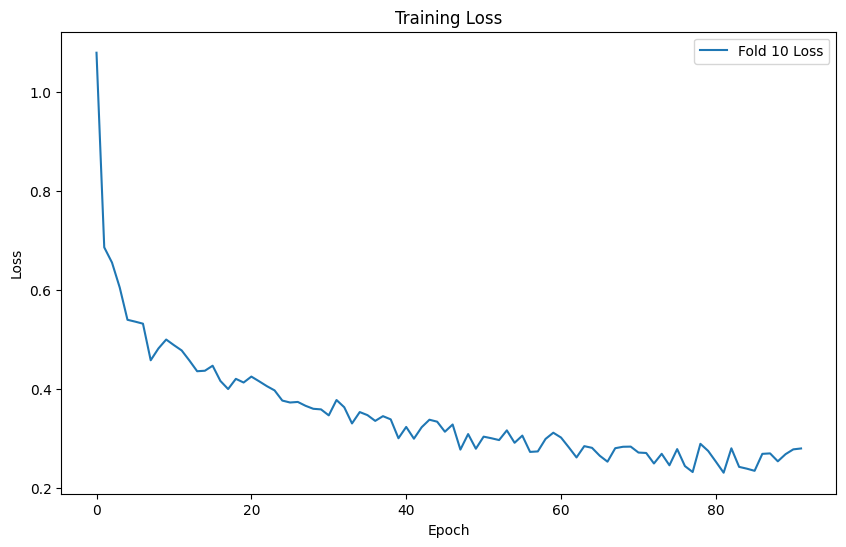

In [5]:
# Create lists to hold the results for plotting
loss_values_folds = []
confusion_matrices = []
roc_curves = []

# Create Data objects for training and testing sets
train_data = create_graph_data(node_features, labels)

# Create DataLoader instances
train_loader = GeometricDataLoader([train_data], batch_size = 1, shuffle = True)

# Initialize and retrain the model with the best parameters
model = AdvancedGNNModel(num_node_features=12, num_classes=2, dropout=final_best_params['dropout'])
optimizer = torch.optim.Adam(model.parameters(), lr=final_best_params['learning_rate'], weight_decay=final_best_params['weight_decay'])
criterion = torch.nn.CrossEntropyLoss()

# Train the model with early stopping
epochs = 200
early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0
training_losses = []

# Retrain on the fold's training data
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Early stopping
    epoch_loss /= len(train_loader)
    training_losses.append(epoch_loss)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot Training Loss for Current Fold
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label=f'Fold {fold + 1} Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Loss')
plt.legend()
plt.show()

Predicting Unknown Data

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


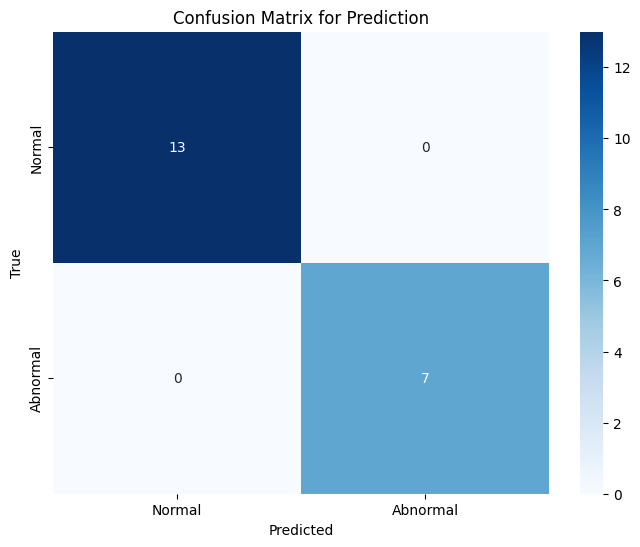

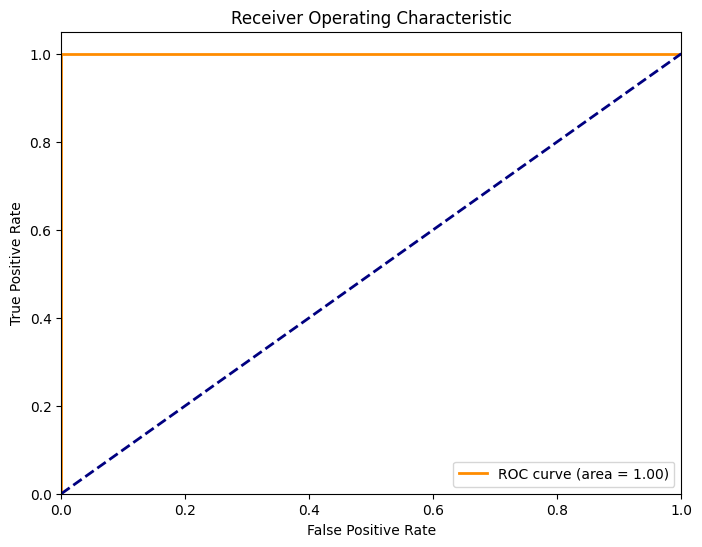

In [6]:
# Extract unknown evaluation data (first 13 rows and last 7 rows combined)
unknown_features = torch.tensor(
    np.vstack((InputData.iloc[:13, 1:13].values, InputData.iloc[-7:, 1:13].values)),
    dtype=torch.float
)
unknown_labels = torch.tensor(
    np.concatenate((InputData.iloc[:13, 14].values, InputData.iloc[-7:, 14].values)),
    dtype=torch.long
)

##unknown_features = torch.tensor(scaler.transform(unknown_features), dtype=torch.float)

# Create Data object for combined data
unknown_graph_data = create_graph_data(unknown_features, unknown_labels)

# Create DataLoader instance
unknown_data_loader = GeometricDataLoader([unknown_graph_data], batch_size=1, shuffle=False)

model.eval()

# Evaluate the model with combined data
unknown_predictions = []
unknown_probs = []

with torch.no_grad():
    for batch in unknown_data_loader:
        output = model(batch)
        _, pred = output.max(dim=1)
        unknown_predictions.extend(pred.tolist())
        unknown_probs.extend(torch.softmax(output, dim=1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
unknown_predictions = np.array(unknown_predictions)
unknown_probs = np.array(unknown_probs)

# Calculate metrics
evluation_accuracy = accuracy_score(unknown_labels, unknown_predictions)
evluation_precision = precision_score(unknown_labels, unknown_predictions, average='macro', zero_division=0)
evaluation_recall = recall_score(unknown_labels, unknown_predictions, average='macro', zero_division=0)
evaluation_f1 = f1_score(unknown_labels, unknown_predictions, average='macro', zero_division=0)
fpr, tpr, _ = roc_curve(unknown_labels, unknown_probs)
evaluation_roc_auc = auc(fpr, tpr)

print(f'Accuracy: {evluation_accuracy:.4f}')
print(f'Precision: {evluation_precision:.4f}')
print(f'Recall: {evaluation_recall:.4f}')
print(f'F1 Score: {evaluation_f1:.4f}')
print(f'ROC AUC: {evaluation_roc_auc:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(unknown_labels, unknown_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Prediction')
plt.show()

# Plot ROC curve and calculate AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {evaluation_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

LIME Explanation

tensor(1)


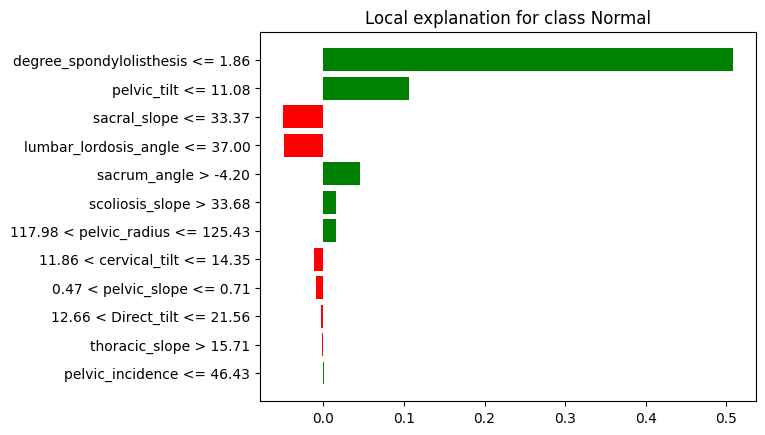

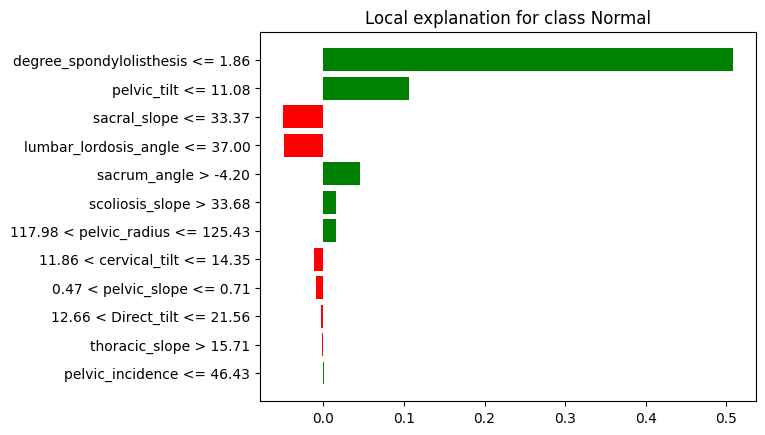

In [7]:
# Convert your torch model's prediction to work with LIME
def gnn_predict_proba(data):
    # data here is expected to be a numpy array for compatibility with LIME
    data_tensor = torch.tensor(data, dtype=torch.float)
    edge_index = torch.tensor([[0],[0]], dtype=torch.long)
    output = model(Data(x=data_tensor, edge_index=edge_index))
    # Converting log probabilities to probabilities for LIME
    proba = F.softmax(output, dim=1).detach().numpy()
    return proba

# Prepare the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train.numpy(),  # Ensure the data is float
    feature_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                     "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                     "sacrum_angle", "scoliosis_slope"],
    class_names=['Abormal', 'Normal'],
    mode='classification'
)

# Choose an instance to explain
i = np.random.randint(0, unknown_features.shape[0])
print(unknown_labels[i])
exp = explainer.explain_instance(unknown_features[i].numpy(), gnn_predict_proba, num_features = 12)

# Display the explanation in the notebook
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()

Graph Data Visualization

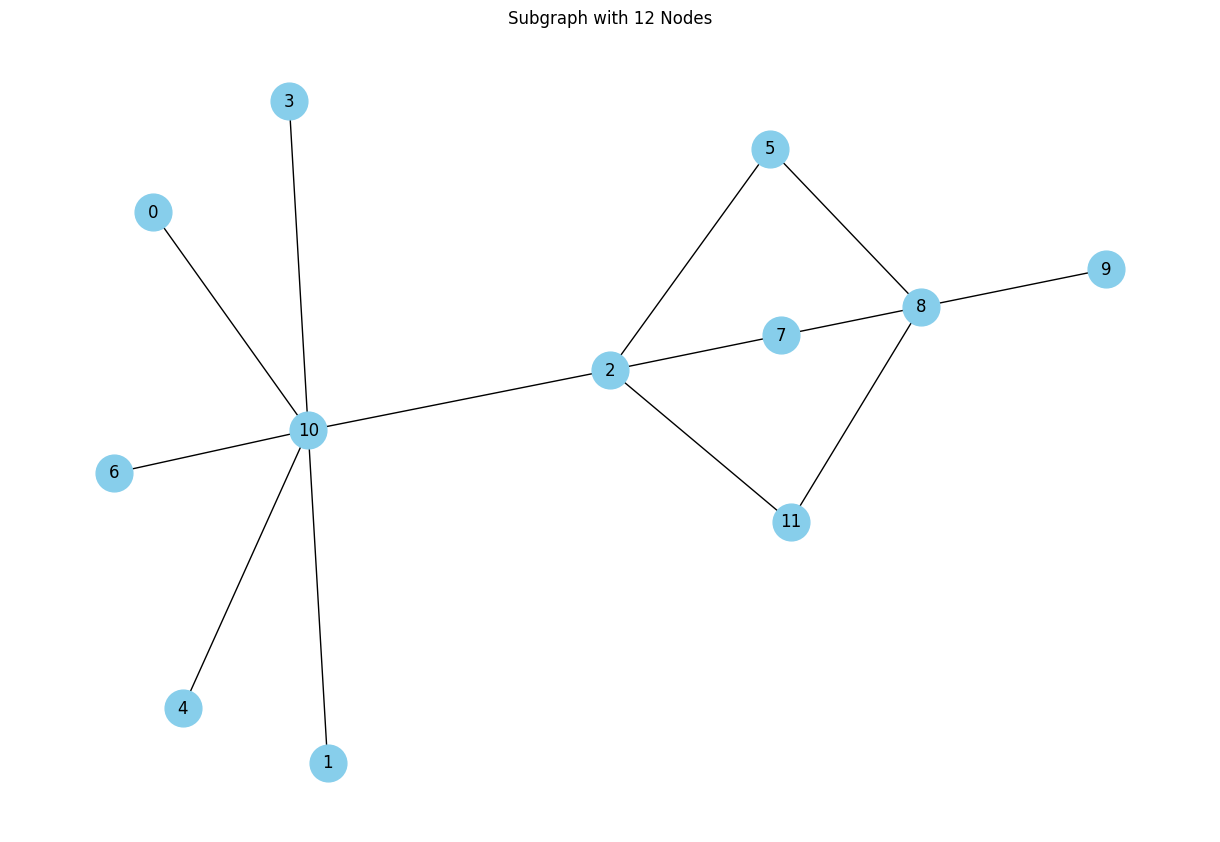

In [8]:
def visualize_graph(edge_index, num_nodes = 12):
    """
    Visualize a subgraph consisting of 'num_nodes' nodes and their corresponding edges.
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i, j in edge_index.t().tolist():
        if i < num_nodes and j < num_nodes:
            G.add_edge(i, j)
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels = True, node_color = 'skyblue', node_size = 700, edge_color = 'k')
    plt.title(f'Subgraph with {num_nodes} Nodes')
    plt.show()

# Visualize subgraph
visualize_graph(create_custom_edge_index(), num_nodes = 12)